# DESAFIO 5: Estructurando un Proyecto de DS (parte III)

In [117]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('bmh')
# mpl.style.use('fivethirtyeight')

## DATASET: COVID 19 Progreso mundial de vacunación

El set de datos incluye información acerca de las vacunaciones por COVID desde Diciembre de 2020 a Marzo de 2022. Se analizó la relación que existen entre el País, fecha, cantidad de personas vacunadas, vacunaciones diarias, personas con esquema completo.

Este conjunto de datos brinda la oportunidad de hacer preguntas como:
* ¿Qué vacuna utiliza cada país?
* ¿En qué país el programa de vacunación está más avanzado?
* ¿Dónde se vacunan más personas por día?

In [118]:
data = pd.read_csv('../datasets/covid_vaccinations/country_vaccinations.csv')
data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


In [119]:
# Convertir DATE a formato fecha
data['date'] = pd.to_datetime(data['date'])

## FEATURE ENGINEERING

### Posibles outliers

Es posible que, en este caso, los valores sean nulos o NaN, ya que el dataset esta separado por días y en esos casos puede haberse no llevado a cabo la vacunación. Pero los vamos a eliminar ya que no aportan a nuestro modelo.

In [120]:
date_before = data.groupby('date').size()

In [121]:
# Eliminar valores NaN de people_vaccinated
data = data[data['people_vaccinated'].notna()]

# Eliminar valores 0.0 de people_vaccinated
data = data.loc[data['people_vaccinated'] != 0.0]

data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,1367.0,0.02,0.02,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
22,Afghanistan,AFG,2021-03-16,54000.0,54000.0,NaN,NaN,2862.0,0.14,0.14,NaN,72.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
44,Afghanistan,AFG,2021-04-07,120000.0,120000.0,NaN,NaN,3000.0,0.30,0.30,NaN,75.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
59,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,8000.0,0.60,0.60,NaN,201.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
78,Afghanistan,AFG,2021-05-11,504502.0,448878.0,55624.0,NaN,13921.0,1.27,1.13,0.14,349.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


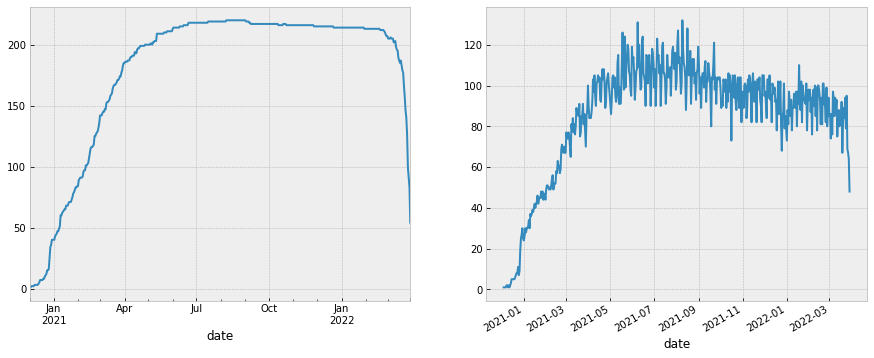

In [122]:
date_after = data.groupby('date').size()

plt.figure(figsize=(15,6))
plt.subplot(121)
date_before.plot.line()
plt.subplot(122)
date_after.plot.line()
plt.show()

### Validación

In [123]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [124]:
# Agrupar por día
period = data.groupby(data['date'].dt.to_period('D')).sum()
y = pd.Series(period['people_vaccinated'].values, index=period.index)
y.shape

(479,)

In [125]:
y_train, y_test = temporal_train_test_split(y, test_size=0.2)
print(y_train.shape, y_test.shape)

(383,) (96,)


### Modelo

In [126]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=36)
forecaster.fit(y_train, fh=fh)

c:\Users\alk10\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ThetaForecaster(sp=36)

In [127]:
# Predicciones
y_pred = forecaster.predict(fh)

### Métricas y Evaluación

In [128]:
# Error absoluto medio (MAE)
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.09284205060335314

Ya que el MEA es el promedio de la diferencia entre el valor pronosticado y el valor real en cada punto que se pronostica, se concidera que a menor valor mejor se adapta el modelo.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

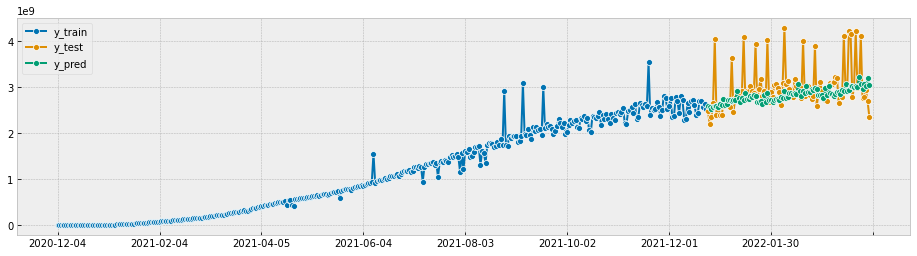

In [129]:
# plotting predictions and past data
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])